본 모델에서 사용할 layer 개수나 hyper parameter같은 거를 정의해둔 탭. 
대부분의 경우 parser로 argument들을 받아서 조정할 수 있게 해두었는데, 나는 colab상에서 돌리는 관계로 그냥 변수로 정의해두었음.

https://github.com/yunjey/pytorch-tutorial/tree/0500d3df5a2a8080ccfccbc00aca0eacc21818db/tutorials/03-advanced/image_captioning 
  
해당 자료를 바탕으로 재구성을 해보았다. 
여기선 resnet152를 썼더라...



본 논문읜 training detail을 살펴보면 512에 embedding했고, LSTM size또한 512라 했으니 다음처럼 정의하자. 

In [ ]:
CNN_feature_num = 512
hidden_layer_depth = 512

우선 우리는 논문에 언급되어 있던 바와 같이, 학습된 CNN을 전이시켜 사용할 것이기에, torchvision에서 pretrained model을 가져온다. 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import time
import os
import copy

일단은 googlenet을 바탕으로 구현한 것 같으니까, google net을 가져와보자.
https://pytorch.org/docs/stable/torchvision/models.html
위에 보면, GoogleNet은 아래와 같은 방식으로 call할 수 있다.

pre trained model은 3channel 로 H x W 의 이미지를 입력으로 받는다. 
0~1로 load되야 하며, mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. 로 normalized되어야 한다네. 

모든 model들이 ImageNet을 바탕으로 pretrain되었으며 google net은 top5 error 10.47로 되어있음.

-> 어차피 학습 시간에 영향이 없으니 ResNet 152로 바꿔서 실험을 추가적으로 해보자.

In [ ]:
model_pt = models.googlenet(pretrained= True);

print(model_pt)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth



GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, trac

model을 출력해보면 inception들 끝에 마지막으로 FC 1024 -> 1000이 있는 것을 볼 수 있다. 

우리는 우리가 원하는 크기의 hidden layer of RNN을 정의해서 사용할 것이기에, 마지막 레이어를 변경해야한다. 

In [ ]:
final_fc_input_dim =  model_pt.fc.in_features
model_pt.fc = nn.Linear(final_fc_input_dim, hidden_layer_depth)

이제 이를 이용해서 class를 정의해보자. 

구현 방법에 따라서, encoder의 출력을 batch normalization을 통과해서 하는 경우도 있는데, 

새로운 NN에 normalized된 데이터를 넣는 것이 합리적으로 여겨져 일단은 추가를 해두었다. 

In [ ]:
class CNN_encoder(nn.Module):
  def __init__(self, out_channels):
    super(CNN_encoder,self).__init__()

    model_pt = models.googlenet(pretrained = True)

    #set gradient as false.
    for p in model_pt.parameters():
      p.requires_grad = False

    #
    final_fc_input_dim = model_pt.fc.in_features
    model_pt.fc = nn.Linear(final_fc_input_dim, out_channels)
    self.cnn = model_pt
    # momentum 0.01문제가 없나? 
    self.bn1 = nn.BatchNorm1d(out_channels, momentum = 0.01)

  def forward(self, x):

    out = self.cnn(x)
    out = self.bn1(out)

    return out




RNN을 정의하기 이전에, word 2 vector를 정의해서 구조를 어떻게 정할지 결정하자. 
여기서 우리는 py coco tool을 통해서 COCO dataset을 import, 이를 바탕으로 모델을 학습시키고자 한다. 


In [ ]:
import pickle #list, class, dict와 같은 자료형을 저장하기 위한 package. (to txt)
import nltk   #data tokenization, parsing등의 natural language preprocessing을 위한 pacakge

from PIL import Image # 이미지 파일을 읽고 쓸때 Image.open, (image instance).save()같은 것을 쓴다.
                      # image crop() 또한 가능하다. 
from collections import Counter # container안에 동일한 값의 자료가 몇개인지 파악하는 것에 사용하는 것.
                                # Dictionary 형태로 return해준다. key는 원래 자료
from pycocotools.coco import COCO  # COCO dataset을 처리하는 package


아래는 word 2 vector를 처리하는 함수이다. dictionary형태를 써서 간단히 정의되어 있다. 

기존의 방법에서 새롭게 바꿀 요소가 없어 보여 차용했다.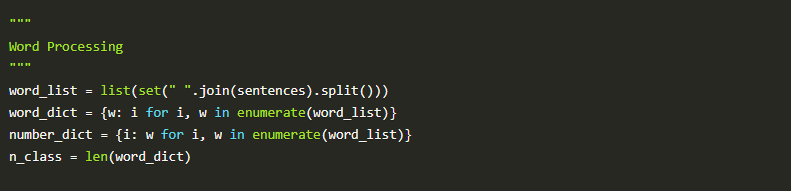

위와 같이 정의 하는 경우도 존재하는데, class 형태로 정의하는게 추후 유연성에 있어 유리할 것 같아 이렇게 아래의 방식을 사용했다.

COCO dataset의 경우 torchvision처럼 자동으로 제공을 해주지 않기에, 아래와 같은 경로를 정의하고 파일을 받아야 한다. 

reference : https://velog.io/@dkdk6638/Pytorch-COCO-Dataset

COLAB 환경이니 current directory에 다운받자.
https://cocodataset.org/#download

위의 링크에서 다운을 받는데, 2017 data는 colab에서 돌리기에 무거운 감이 없잖아 있으니, 2014 버전을 사용하자.


In [ ]:
%mkdir coco_data
!wget http://images.cocodataset.org/zips/train2014.zip -P ./coco_data/
!unzip ./coco_data/train2014.zip -d ./coco_data/
!rm ./coco_data/train2014.zip

!wget http://images.cocodataset.org/zips/val2014.zip -P ./coco_data/
!unzip ./coco_data/val2014.zip -d ./coco_data/
!rm ./coco_data/val2014.zip

!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P ./coco_data/
!unzip ./coco_data/annotations_trainval2014.zip -d ./coco_data/
!rm ./coco_data/annotations_trainval2014.zip






In [ ]:
class Vocabulary(object):
  def __init__(self):
    # dictionary 형태로 word 2 vec을 저장해둔다.
    self.word2idx = {}
    self.idx2word = {}
    # 현재 idx. 
    self.idx = 0
  
  def add_word(self ,word):
    if not word in self.word2idx:
      self.word2idx[word] = self.idx
      self.idx2word[self.idx] = word
      self.idx +=1
    #두개의 dictionary에 값을 입력한다.
 
  #두개는 duck type으로 함수가 호출되었을 때, 또 len으로 호출되었을때 작동을 정의함. (duck type)
  def __call__(self,word):
    if not word in self.word2idx:
      return self.word2idx['<not in list>']
    return self.word2idx[word]

  def __len__(self):
    return len(self.word2idx)
  


COCO dataset을 이용해서 위의 word 2 vector의 dictionary를 채워줄 차례이다. 

입력받은 데이터를 tokenization한 뒤 넣어준다. 

COCO dataset에 들어있는 모든 문자를 넣을경우, 1번이나 2번 나온 문자의 경우 해당 문장에 overfitting 될 가능성도 크고 해당 문자가 사용된 출력이 나와도 합리적인 출력이라 판단하기 어렵다. 따라서 Counter() 패키지를 사용해서 특정 회수 이상 나온 caption만을 사용하자. 


{"image_id": 111014,"id": 141808,"caption": "A toilet and a be day with gold handles."}

위와같이 json파일이 구성되어 있다. json파일을 불러오는 방식은 자세히 이해하지 못햇지만, id라는 key를 정의해서 이를 호출해야한다. 

In [ ]:
def COCO_w2v(caption_dir, threshold):
  coco = COCO(caption_dir)
  cnt = Counter()
  ids = coco.anns.keys()
  # caption은 json file로 되어있는데, 해당 파일의 annotation key를 list로 추출하는 것이다.

  
  for i, id in enumerate(ids):
    #id는 iterator, i는 0부터 시작하는 index
    caption = str(coco.anns[id]['caption'])
    #소문자로 만들고 token으로 바꾸는것
    #array로 return하는데 
    # " ".join(caption.lower()).split()으로 해도 동일한 결과가 나올것 같긴함.  
    tokens =caption.lower().split()
    #tokens = nltk.tokenize.word_tokenize(caption.lower())
    cnt.update(tokens)
    #counter의 경우 list를 누적하면서 새기 때문에, update로 token들을 집어 넣어주면, counter안에서 알아서 넣어준다.

  #threshold보다 큰 것만 words에 저장하기.
  #counter는 dictionary이기에 cnt.items()는 tuple형으로 데이터를 묶어서 return 해줄 것이다.

  words = [word for word, count in cnt.items() if count >=threshold]

  #이제 vocab에 단어들을 삽인할 것인데, special starting, ending을 넣어줘야 한다. 

  vocab = Vocabulary()
  vocab.add_word('<start>')
  vocab.add_word('<end>')
  vocab.add_word('<not in list>')
  #원 코드에는 pad가 존재하는데, 이는 언제 쓰이는지 잘 모르겠다.

  #이제 단어들을 삽입해주자,.
  
  for i, word in enumerate(words):
    vocab.add_word(word)
  return vocab

  

위의 함수에 caption파일의 경로를 넣어줌으로 main함수에서 voabulary를 initalize할 수 있다.


In [ ]:
val_cap_path = "./coco_data/annotations/captions_val2014.json"
train_cap_path = "./coco_data/annotations/captions_train2014.json"
train_img_path = "./coco_data/train2014"
val_img_path = "./coco_data/val2014"

이제 word vector가 정의되었으니 RNN을 decoder를 정의해보자. 

In [ ]:
from  torch.nn.utils.rnn import pack_padded_sequence


class RNN_decoder(nn.Module):
  def __init__(self,feature_size,hidden_size, vocab_size, num_layers, max_seq_length = 20 ):
    super(RNN_decoder,self).__init__()
    #feature size를 LSTM의 입력의 기준 크기로 정의하는 것임. 
    #근데 이러면, LSTM에서 hiddenstate로 mapping하는 array랑 embedding array를 이중으로 학습시키는거 아닌가?
    #근데 그렇다 한들 비선형성이 없어서 사실상 1개처럼 작동할 것이라 문제는 없다.
    self.embedding = nn.Embedding(vocab_size,feature_size)
    self.lstm = nn.LSTM(feature_size, hidden_size, num_layers, batch_first = True)
    self.output = nn.Linear(hidden_size, vocab_size)
    self.max_seq_length = max_seq_length

  def forward(self, features, captions, lengths):
    embeddings = self.embedding(captions)
    # 첫번째 입력인 features의 경우 feature_size x 1짜리 array로 정의되어 있는데, 이는 t=-1에서의 word input과
    # 같으니까, 이렇게 cat으로 array를 합쳐준다.
    # 그러면 CNN feature이 출력되는 곳에서 <start>가 나오도록 학습을 시키겠지.
    embeddings = torch.cat((features.unsqueeze(1),embeddings),1)
    packed = pack_padded_sequence(embeddings, lengths  , batch_first = True)
    #원 코드는 length를 늘려주지 않는데, 난 늘려야 한다 생각해서 수정했음.
    hiddens, _ = self.lstm(packed)

    #근데 출력을 이렇게 하는게 합리적인지는 모르겠음. hiddens.squeeze(1)을 하는게 더 합리적이지 않나?
    
    outputs = self.output(hiddens[0])

    return outputs



  #sampling은 아래의 함수를 통해서 이뤄진다. 시간의 부족으로 그저 코드를 가져왔다.
  def sample(self, features, states=None):
    """Generate captions for given image features using greedy search."""
    sampled_ids = []
    inputs = features.unsqueeze(1)
    for i in range(self.max_seq_length):
      hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
      outputs = self.output(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
      _, predicted = outputs.max(1)                        # predicted: (batch_size)
      sampled_ids.append(predicted)
      inputs = self.embedding(predicted)                       # inputs: (batch_size, embed_size)
      inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
    sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
    return sampled_ids













In [ ]:
#%pip install tensorboardX

In [ ]:
#from tensorboardX import SummaryWriter

In [ ]:
import torch.utils.data as data

data_loading을 하는 함수를 만들자. COCO caption을 loading해서 word vector library를 만들었지만, 이미지랑 다 같이 세트로 불러와야지.

root는 이미지 경로를 의미하니 적당히 넘겨주면 된다. path는 앞서 지정한 train path를 넘겨주면 된다.

In [ ]:
class COCO_dataset(data.Dataset):
  def __init__(self, root, path, vocab, transform = None):
    #초기화는 들어온 데이터를 istance안에 저장하는 과정이 전부임.
    self.root =root
    self.coco = COCO(path)
    self.ids = list(self.coco.anns.keys())
    self.vocab = vocab
    self.transform = transform
  def __getitem__(self, index):
    #이미지랑 caption을 쌍으로 출력해주길 원한다. .item()이 호출되었을때
    #여기는 COCO wd2v이랑 동일한 구성임. 이미지 불러온느 것 제외하고선.
    ann_id = self.ids[index] # annotation id
    caption = self.coco.anns[ann_id]['caption']
    img_id = self.coco.anns[ann_id]['image_id']

    im_path = self.coco.loadImgs(img_id)[0]['file_name'] 
    #이미지가 저장된 dir를 배열로 저장한다. 
    #PIL library에서 근원한 것이다.
    #아래는 라이브러리에 내장된 함수들을 통한 변환
    image = Image.open(os.path.join(self.root, im_path)).convert('RGB')
    #주어진 preprocessing대로 transform을 시행한다.
    if self.transform is not None:
      image = self.transform(image)

    #caption index화 하기.
    tokens = caption.lower().split()
    caption_id = []
    caption_id.append(vocab('<start>'))
    caption_id.extend([vocab(token) for token in tokens])
    caption_id.append(vocab('<end>'))
    #토치 텐서로 변환 
    target = torch.Tensor(caption_id)

    return image, target
  def __len__(self):
    return len(self.ids)

# 미니 배치를 형성하는 부분인데, 시간이 부족해 일단 코드를 차용한다. 

def collate_fn(data):
  """Creates mini-batch tensors from the list of tuples (image, caption).
  
  We should build custom collate_fn rather than using default collate_fn, 
  because merging caption (including padding) is not supported in default.
  Args:
      data: list of tuple (image, caption). 
          - image: torch tensor of shape (3, 256, 256).
          - caption: torch tensor of shape (?); variable length.
  Returns:
      images: torch tensor of shape (batch_size, 3, 256, 256).
      targets: torch tensor of shape (batch_size, padded_length).
      lengths: list; valid length for each padded caption.
  """
  # Sort a data list by caption length (descending order).
  data.sort(key=lambda x: len(x[1]), reverse=True)
  images, captions = zip(*data)

  # Merge images (from tuple of 3D tensor to 4D tensor).
  images = torch.stack(images, 0)

  # Merge captions (from tuple of 1D tensor to 2D tensor).
  lengths = [len(cap) for cap in captions]
  targets = torch.zeros(len(captions), max(lengths)).long()
  for i, cap in enumerate(captions):
      end = lengths[i]
      targets[i, :end] = cap[:end]        
  return images, targets, lengths



#위에 정의한 COCO_dataset이 출력된다. data_loader에 맞게 실행된다,
def get_loader(root, path, vocab, transform,batch_size, shuffle, num_workers):
  coco = COCO_dataset(root= root, path = path, vocab = vocab, transform=transform)
  data_loader = torch.utils.data.DataLoader(dataset = coco, batch_size= batch_size, shuffle = shuffle, num_workers=num_workers, collate_fn = collate_fn)

  return data_loader

이제 training을 위한 함수를 정의할 차례이다.

RNN의 경우 training 이외에도 sample을 출력하기 위한 함수의 정의도 필요하다. 

In [ ]:
CROP_SIZE = 224
THRESHOLD = 5
#논문에서도 최소 5번 이상 등장하는 대상에 대해서 논의를 했음.
NUM_LAYERS = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
LOG_STEP = 100
BATCH_SIZE = 128
NUM_WORKERS = 2

한번 훈련을 돌려보니 224x600같은 crop size에 맞지 않는 이미지들이 존재한다. 그래서, resizing이 필수적으로 이뤄져야 한다. 
용량이 부족한 관계로, orginal image를 삭제하는 형식으로 진행한다. 

In [ ]:
%mkdir ./coco_data/re_train2014

In [ ]:
resized_train_img = './coco_data/re_train2014'
RESIZED_SIZE = [256,256]

In [ ]:
images = os.listdir(train_img_path)
num_images = len(images)
for i, image in enumerate(images):
  with open(os.path.join(train_img_path,image), 'r+b') as f:
    with Image.open(f) as img:
      img = img.resize(RESIZED_SIZE, Image.ANTIALIAS)
      img.save(os.path.join(resized_train_img,image),img.format)
  os.remov###e(os.path.join(train_img_path,image))


In [ ]:
%rm  -r ./save_model

In [ ]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if __name__ == '__main__':
  
  #저장 하는 곳을 정의하자 
  if not os.path.isdir('save_model'):
    os.mkdir('save_model')
  
  #image preprocessing.
  transform = transforms.Compose([
                                  transforms.RandomCrop(CROP_SIZE),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
                                  #Image Net의 normalize를 따라감. 
                                  ])
  #vocab library를 제작하자.
  #원래의 코드는 pickle로 저장된 vocab class를 불러오는 것인데, 지금은 그냥 바로 호출해서 pickle package를 사용하지 않게 되었다.

  vocab = COCO_w2v(train_cap_path, THRESHOLD)

  '''
  get_loader()를 구현해야 한다.

  '''

  data_loader = get_loader(resized_train_img,train_cap_path, vocab=vocab, transform = transform,batch_size = BATCH_SIZE, shuffle = True, num_workers =NUM_WORKERS )

  encoder = CNN_encoder(CNN_feature_num).to(device)
  decoder = RNN_decoder(CNN_feature_num, hidden_layer_depth, len(vocab), NUM_LAYERS).to(device)

  criterion = nn.CrossEntropyLoss()
  #learning parameters
  params = list(decoder.parameters()) + list(encoder.parameters()) 
  optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum = 0 , weight_decay = 0)
  #원 논문에서는 SGD를 통해서 구현을 했고 LR decay는 없이 no momentum으로 학습을 진행했다.
  #Adam이 나오기 전이라 그런거 같은데, adam쓰는게 더 합리적일지도.




  # training 과정
  total_step = len(data_loader)
  for epoch in range (NUM_EPOCHS):
    for i, (images, captions, lengths) in enumerate(data_loader):

      images = images.to(device)
      captions = captions.to(device)
      targets = pack_padded_sequence(captions,lengths,batch_first=True)[0]

      features =encoder(images)
      outputs = decoder(features, captions, lengths)
      loss = criterion(outputs, targets)
      #back propa
      decoder.zero_grad()
      encoder.zero_grad()
      loss.backward()
      optimizer.step()


      if i % LOG_STEP == 0:
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'.format(epoch, NUM_EPOCHS, i, total_step, loss.item(), np.exp(loss.item()))) 
                
      # Save the model checkpoints
      if (i+1) % LOG_STEP == 0:
        torch.save(decoder.state_dict(), os.path.join('./save_model', 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
        torch.save(encoder.state_dict(), os.path.join('./save_model', 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))

  # testing 과정




loading annotations into memory...
Done (t=0.60s)
creating index...
index created!
loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
Epoch [0/10], Step [0/3236], Loss: 9.3911, Perplexity: 11981.1450
Epoch [0/10], Step [100/3236], Loss: 9.3781, Perplexity: 11827.1029
Epoch [0/10], Step [200/3236], Loss: 9.3684, Perplexity: 11712.8920
Epoch [0/10], Step [300/3236], Loss: 9.3545, Perplexity: 11551.0241
Epoch [0/10], Step [400/3236], Loss: 9.3476, Perplexity: 11471.5545
Epoch [0/10], Step [500/3236], Loss: 9.3297, Perplexity: 11267.2294
Epoch [0/10], Step [600/3236], Loss: 9.3192, Perplexity: 11150.2448
Epoch [0/10], Step [700/3236], Loss: 9.3044, Perplexity: 10986.4460
Epoch [0/10], Step [800/3236], Loss: 9.3039, Perplexity: 10980.3184
Epoch [0/10], Step [900/3236], Loss: 9.2861, Perplexity: 10787.4688
Epoch [0/10], Step [1000/3236], Loss: 9.2723, Perplexity: 10639.3335
Epoch [0/10], Step [1100/3236], Loss: 9.2576, Perplexity: 10484.0199
Epoch [0/10], Step

테스트 결과를 살펴보자. 

In [ ]:
encoder_path = './save_model/encoder-10-3200.ckpt'
decoder_path = './save_model/decoder-10-3200.ckpt'


test image의 경우도 224,224로 resize를 거쳐야 한다.

In [ ]:
%mkdir ./coco_data/re_val2014

In [ ]:
#!zip -r save_model.zip ./save_model

  adding: save_model/ (stored 0%)
  adding: save_model/decoder-10-1700.ckpt (deflated 8%)
  adding: save_model/decoder-4-300.ckpt (deflated 8%)
  adding: save_model/decoder-2-2400.ckpt


zip error: Interrupted (aborting)


In [ ]:
resized_val_img = './coco_data/re_val2014'
VAL_RESIZED_SIZE = [224,224]

In [ ]:
images = os.listdir(val_img_path)
num_images = len(images)
for i, image in enumerate(images):
  with open(os.path.join(val_img_path,image), 'r+b') as f:
    with Image.open(f) as img:
      img = img.resize(VAL_RESIZED_SIZE, Image.ANTIALIAS)
      img.save(os.path.join(resized_val_img,image),img.format)
  os.remove(os.path.join(val_img_path,image))

<start> a man in a man in a man in a man in a man <end>


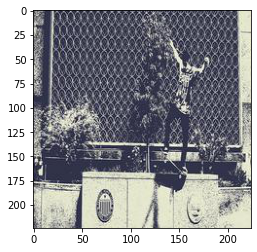

In [ ]:
import random
#train과 같이 이미지의 preprocessing을 처리한다.
def load_image(image_path, transform=None):
  images = os.listdir(image_path)
  num_images = len(images)
  id_rand = random.randrange(0,num_images-1)
  image = Image.open(os.path.join(image_path,images[id_rand])).convert('RGB')
  
  if transform is not None:
    image = transform(image).unsqueeze(0)
  
  return image, images[id_rand]

##########################################

transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
# Load vocabulary wrapper
#vocab = COCO_w2v(train_cap_path, THRESHOLD)

# Build models
encoder = CNN_encoder(CNN_feature_num).to(device).eval()
decoder = RNN_decoder(CNN_feature_num, hidden_layer_depth, len(vocab), NUM_LAYERS)
encoder = encoder.to(device)
decoder = decoder.to(device)

# Load the trained model parameters
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

# Prepare an image
image , im_name = load_image(resized_val_img, transform)
image_tensor = image.to(device)
    
# Generate an caption from the image
feature = encoder(image_tensor)
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    
# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids:
  word = vocab.idx2word[word_id]
  sampled_caption.append(word)
  if word == '<end>':
      break
sentence = ' '.join(sampled_caption)
    
# Print out the image and the generated caption
print (sentence)
image = Image.open(os.path.join(resized_val_img,im_name))
plt.imshow(np.asarray(image))


In [ ]:
#vocab = COCO_w2v(train_cap_path, THRESHOLD)
print(vocab.word2idx)

{'<start>': 0, '<end>': 1, '<not in list>': 2, 'a': 3, 'very': 4, 'clean': 5, 'and': 6, 'well': 7, 'decorated': 8, 'empty': 9, 'bathroom': 10, 'panoramic': 11, 'view': 12, 'of': 13, 'kitchen': 14, 'all': 15, 'its': 16, 'appliances.': 17, 'blue': 18, 'white': 19, 'with': 20, 'butterfly': 21, 'themed': 22, 'wall': 23, 'tiles.': 24, 'photo': 25, 'dining': 26, 'room': 27, 'stop': 28, 'sign': 29, 'across': 30, 'the': 31, 'street': 32, 'from': 33, 'red': 34, 'car': 35, 'vandalized': 36, 'beetle': 37, 'on': 38, 'road': 39, 'border': 40, 'butterflies': 41, 'paint': 42, 'walls': 43, 'above': 44, 'it.': 45, 'an': 46, 'angled': 47, 'beautifully': 48, 'bathroom.': 49, 'two': 50, 'people': 51, 'are': 52, 'walking': 53, 'down': 54, 'beach.': 55, 'sink': 56, 'toilet': 57, 'inside': 58, 'small': 59, 'black': 60, 'square': 61, 'tile': 62, 'floor': 63, 'that': 64, 'needs': 65, 'repairs': 66, 'vanity': 67, 'contains': 68, 'sinks': 69, 'towel': 70, 'for': 71, 'each.': 72, 'several': 73, 'metal': 74, 'ball